In [18]:
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'

In [137]:
import numpy as np
from keras import models
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.layers import Convolution2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, UpSampling2D
from keras.layers.core import Dense, Activation, Dropout, Flatten, Reshape
from keras.regularizers import l1
import keras.backend as K
# from autoencoder_layers import DependentDense, Deconvolution2D, DePool2D
# from helpers import show_representations

GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'
from scipy.misc import imresize
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
from keras import optimizers
from keras.models import Model


In [140]:
Convolution2D?

In [141]:
Convolution2D?

In [228]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import optimizers
import h5py
import cv2
from scipy.misc import imresize

def get_data():
    with h5py.File(GTEx_directory + '/data/better_covering_patches/' + 'GTEX-111YS-0626_128.hdf5','r') as f:
        data = f['patches'].value
    return data

def process_image(x):
    x = imresize(x, (28,28))
#     x = cv2.cvtColor(x , cv2.COLOR_BGR2GRAY)
    return x


def build_models():
    c1 = Convolution2D(64, 3, 3, border_mode='same', input_shape=(28, 28, 3))
    c2 = Convolution2D(32, 3, 3, border_mode='same')
    mp1 = MaxPooling2D(pool_size=(2, 2))
    mp2 = MaxPooling2D(pool_size=(2, 2))
    dc1 = Conv2DTranspose(32, 3, border_mode='same')
    dc2 = Conv2DTranspose(3, 3, border_mode='same')
    up1 = UpSampling2D(size=(2, 2))
    up2 = UpSampling2D(size=(2, 2))
    d = Dense(128, activity_regularizer=l1(1e-5))




    # =========      ENCODER     ========================

    def generate_encoder():
        model = models.Sequential()
        model.add(c1)
        model.add(Activation('tanh'))
        model.add(mp1)
        model.add(Dropout(0.5))
        model.add(c2)
        model.add(Activation('tanh'))
        model.add(mp2)
        model.add(Dropout(0.5))
        model.add(Flatten())
        model.add(Dropout(0.5))
        dependent_dense_size = model.layers[-1].output_shape[-1]
        model.add(d)
        model.add(Activation('tanh'))
        return model

    # =========      DECODER     ========================

    def generate_decoder():
        model = models.Sequential()
        model.add(Dense(7*7*32, input_shape=(128,)))
        model.add(Activation('tanh'))
        model.add(Dropout(0.5))
        model.add(Reshape((7, 7, 32)))
        model.add(up1)
        model.add(dc1)
        model.add(Activation('tanh'))
        model.add(Dropout(0.5))
        model.add(up2)
        model.add(dc2)
        model.add(Activation('tanh'))
        model.add(Dropout(0.5))
        return model

    encoder = generate_encoder()
    decoder = generate_decoder()

    autoencoder = Model(encoder.input, decoder(encoder(encoder.input)))
    return autoencoder, encoder, decoder

In [175]:
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25_input (InputLayer) (None, 28, 28, 3)         0         
_________________________________________________________________
sequential_25 (Sequential)   (None, 128)               221088    
_________________________________________________________________
sequential_26 (Sequential)   (None, 28, 28, 3)         212387    
Total params: 433,475.0
Trainable params: 433,475.0
Non-trainable params: 0.0
_________________________________________________________________


In [176]:
autoencoder, encoder = build_models()
data = get_data()
data = np.array(list(map(process_image,data)))
x_train = data[0:7000,:,:]
x_test = data[7000:,:,:]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# x_train = x_train.reshape((len(x_train), x_test.shape[1], x_test.shape[1],3))
# x_test = x_test.reshape((len(x_test), x_test.shape[1], x_test.shape[1], 3))
print (x_train.shape)
print (x_test.shape)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), input_shape=(28, 28, 3..., padding="same")`
  '` call to the Keras 2 API: ' + signature)
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
  '` call to the Keras 2 API: ' + signature)
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(32, 3, padding="same")`
  '` call to the Keras 2 API: ' + signature)
/homes/willj/anaconda3/envs/GTEx/lib/python3.5/site-packages/keras/legacy/interfaces.py:86: UserWarning: Update your `Conv2DTranspose` call to the Keras 2 API: `Conv2DTranspose(3, 3, padding="same")`
  '` call to the Keras 2 API: ' + signature)


(7000, 28, 28, 3)
(1534, 28, 28, 3)


In [178]:
autoencoder.fit(x_train, x_train,
                epochs=5,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 7000 samples, validate on 1534 samples
Epoch 1/5
7000/7000 [==============================] - 49s - loss: 7.9872 - val_loss: 0.6806
Epoch 2/5
7000/7000 [==============================] - 49s - loss: 7.8725 - val_loss: 0.7500
Epoch 3/5
7000/7000 [==============================] - 49s - loss: 7.8183 - val_loss: 0.9342
Epoch 4/5
7000/7000 [==============================] - 48s - loss: 7.7519 - val_loss: 1.1321
Epoch 5/5
7000/7000 [==============================] - 48s - loss: 7.6639 - val_loss: 1.9626


In [179]:
# encode and decode some digits
# note that we take them from the *test* set
decoded_imgs = autoencoder.predict(x_test)
#  = decoder.predict(encoded_imgs)

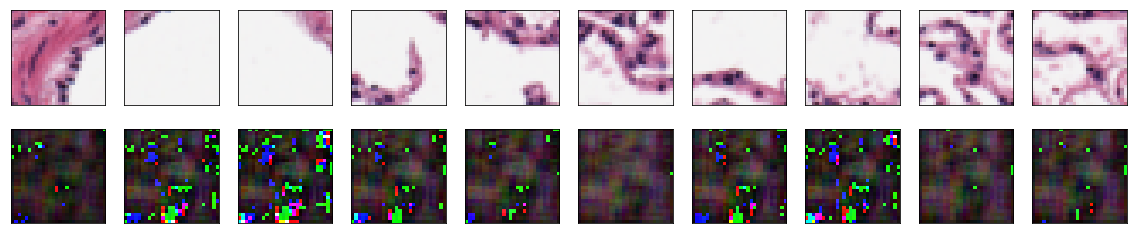

In [183]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt
%matplotlib inline

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [224]:
%reset -f 
import h5py
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adadelta
from scipy.misc import imresize
GTEx_directory = '/hps/nobackup/research/stegle/users/willj/GTEx'

def get_data():
    with h5py.File(GTEx_directory + '/data/better_covering_patches/' + 'GTEX-111YS-0626_128.hdf5','r') as f:
        data = f['patches'].value
    return data

def process_image(x):
    x = imresize(x, (28,28))
#     x = cv2.cvtColor(x , cv2.COLOR_BGR2GRAY)
    return x

input_img = Input(shape=(28, 28, 3))  # adapt this if using `channels_first` image data format

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

ada = Adadelta(lr=0.05)
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer=ada, loss='binary_crossentropy')

In [225]:
from keras.datasets import mnist
import numpy as np

# (x_train, _), (x_test, _) = mnist.load_data()
# x_train = x_train.astype('float32') / 255.
# x_test = x_test.astype('float32') / 255.
# x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
# x_train = x_train[0:6000]
# x_test = x_test[0:1000]

data = get_data()
data = np.array(list(map(process_image,data)))
x_train = data[0:7000,:,:]
x_test = data[7000:,:,:]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print (x_train.shape)
print (x_test.shape)



(7000, 28, 28, 3)
(1534, 28, 28, 3)


In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=200,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 7000 samples, validate on 1534 samples
Epoch 1/200
7000/7000 [==============================] - 15s - loss: 0.6968 - val_loss: 0.6956
Epoch 2/200
7000/7000 [==============================] - 15s - loss: 0.6936 - val_loss: 0.6922
Epoch 3/200
7000/7000 [==============================] - 15s - loss: 0.6899 - val_loss: 0.6864
Epoch 4/200
7000/7000 [==============================] - 15s - loss: 0.6769 - val_loss: 0.6459
Epoch 5/200
6784/7000 [============================>.] - ETA: 0s - loss: 0.5836

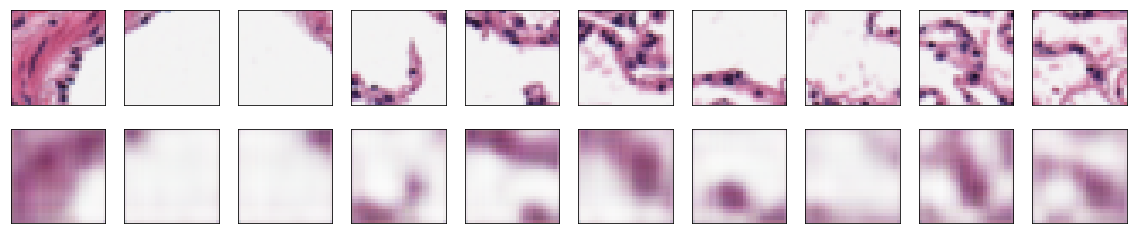

In [227]:
import matplotlib.pyplot as plt
%matplotlib inline
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()